In [1]:
# Written by Constantijn Bicker Caarten
# Last updated: 07-07-2017
#
#
# This code contains example of how
# the gathered data can be visualised.

# Imports

In [2]:
from socket import error as socket_error
from urllib.request import urlopen
from dns.query import udp, tcp
from bs4 import BeautifulSoup
from dns.resolver import dns
from uuid import uuid4
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import copy
import json
import csv
import os

%matplotlib inline

# Constants

In [3]:
PIE = (6, 6)

NEWLINE = '\n'

# Functions

In [4]:
def write_list(fn, data):
    '''Writes a list to a file with each value on a new line'''
    with open(fn, 'w') as f:
        for datum in data:
            f.write(datum + NEWLINE)
        
def append_list(fn, data):
    '''Appends a list to a file with each value on a new line'''
    with open(fn, 'a') as f:
        for datum in data:
            f.write(datum + NEWLINE)
    
def read_list(fn):
    '''Reads a file and '''
    with open(fn, 'r') as f:
        return [line.strip(NEWLINE) for line in f]
    
def write_json(fn, data):
    with open(fn, 'w') as f:
        f.write(json.dumps(data))
            
def read_json(fn):
    '''Read a json file (fn) and returns it as a dictionary'''
    with open(fn, 'r') as f:
        return json.loads(f.read())

In [85]:
def set_text(ax, title, x, y):
    ax.set_title(title)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    
def save_fig(ax, fn):
    fig = ax.get_figure()
    fig.savefig('imgs/{}.pdf'.format(fn))

# Top-Level Domains

In [59]:
data_tlds = read_json('data/data_tlds.json')

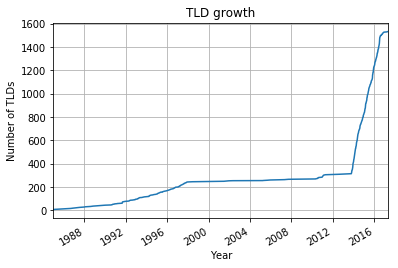

In [60]:
df_tlds = pd.DataFrame(data_tlds)
df_tlds['creation_date'] = pd.to_datetime(df_tlds['creation_date'])
ax = df_tlds.creation_date.value_counts().sort_index().cumsum().plot(grid=True)
set_text(ax, 'TLD growth', 'Year', 'Number of TLDs')

In [56]:
df_orgs = pd.DataFrame(data_tlds)
rows = []

df_orgs.index = df_orgs.tld
del df_orgs['tld']
del df_orgs['creation_date']

df_orgs.reset_index(inplace=True)
df_orgs.apply(lambda row: [rows.append([row['tld'], org]) for org in row.organisations], axis = 1)
df_orgs = pd.DataFrame(rows, columns=df_tlds.columns).set_index(['tld'])

ValueError: could not broadcast input array from shape (2) into shape (3)

In [61]:
max_orgs = 32

ax = df_orgs.organisations.value_counts().head(max_orgs).plot.barh(figsize = (6, int(max_orgs / 4)))
ax.set_xlabel('Number of TLDs')
ax.set_ylabel('Organisation')
fig = ax.get_figure()
fig.savefig("imgs/orgs.pdf")

TypeError: unhashable type: 'list'

In [62]:
# 2013-10-23 is the creation date of the first new gtld program tld
new_tlds = df_tlds[(df_tlds.creation_date >= '2013-10-23')].tld
old_tlds = df_tlds[(df_tlds.creation_date < '2013-10-23')].tld
cctlds = df_tlds.loc[df_tlds.type == 'country-code'].tld
gtlds = df_tlds.loc[df_tlds.type == 'generic'].tld

In [63]:
tld_groups = {'old TLDs': old_tlds, 
              'new TLDs': new_tlds, 
              'gTLDs': gtlds, 
              'ccTLDs': cctlds}

# Name Servers

In [64]:
data_nss = read_json('data/data_ns.json')

In [65]:
df_nss = pd.DataFrame(data_nss)
maxc = df_nss.tld.value_counts().max()
minc = df_nss.tld.value_counts().min()

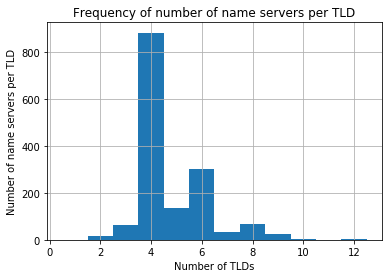

In [69]:
ax = df_nss.tld.value_counts().hist(bins = maxc - minc, range = (minc, maxc), align = 'left')
set_text(ax, 'Frequency of number of name servers per TLD', 'Number of TLDs', 'Number of name servers per TLD')

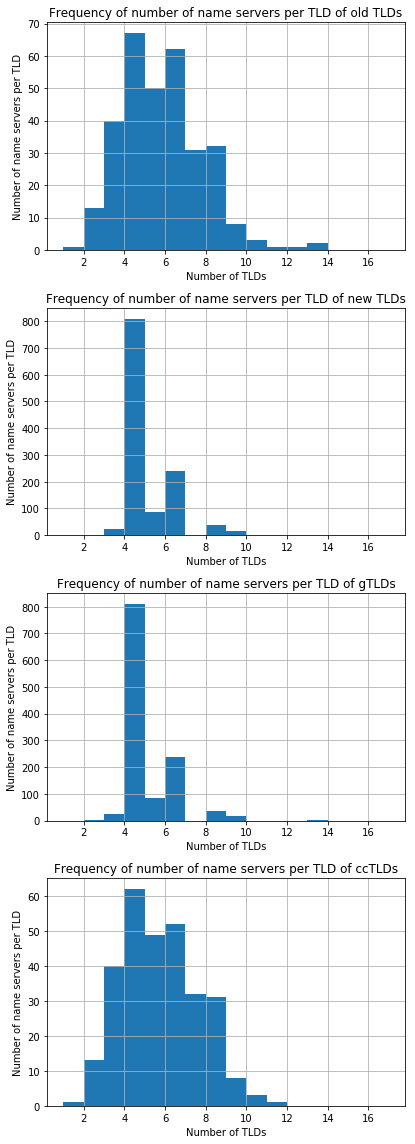

In [98]:
fig, axes = plt.subplots(nrows=len(tld_groups))

for i, group in enumerate(tld_groups):
    ax = df_nss[df_nss.tld.isin(tld_groups[group])].tld.value_counts().hist(bins = maxc - minc,
                                                                            range = (minc, maxc),
                                                                            figsize = (6, 4 * len(tld_groups)),
                                                                            ax = axes[i])
    set_text(ax, 
             'Frequency of number of name servers per TLD of {}'.format(group), 
             'Number of TLDs', 
             'Number of name servers per TLD')
    
fig.tight_layout()

# Network Diversity

In [74]:
data_asns = read_json('data/data_asns.json')
data_ips = read_json('data/data_ips.json')

In [90]:
df_asns = pd.DataFrame(data_asns)

In [91]:
maxc = df_asns.groupby('tld').asn.nunique().max()
minc = df_asns.groupby('tld').asn.nunique().min()

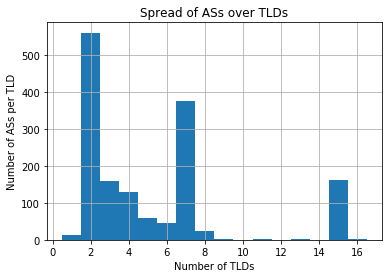

In [92]:
ax = df_asns.groupby('tld').asn.nunique().hist(bins = maxc - minc, range = (minc, maxc), align='left')
set_text(ax, 'Spread of ASs over TLDs', 'Number of TLDs', 'Number of ASs per TLD')

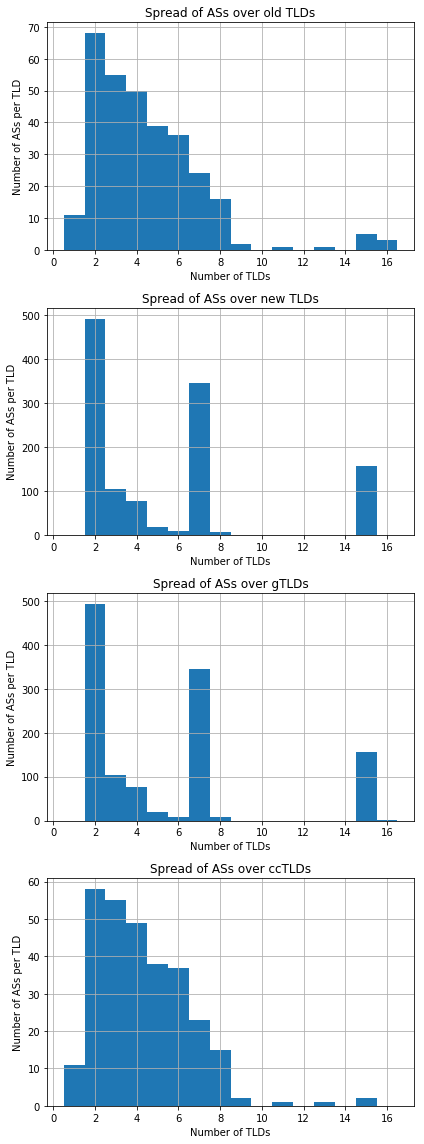

In [97]:
fig, axes = plt.subplots(nrows=len(tld_groups))

for i, group in enumerate(tld_groups):
    ax = df_asns[df_asns.tld.isin(tld_groups[group])].groupby('tld').asn.nunique().hist(bins = maxc - minc, 
                                                                                        range = (minc, maxc), 
                                                                                        align='left',
                                                                                        figsize = (6, 4 * len(tld_groups)),
                                                                                        ax = axes[i])
    
    set_text(ax, 'Spread of ASs over {}'.format(group), 'Number of TLDs', 'Number of ASs per TLD')
    
fig.tight_layout()

In [100]:
maxc = df_asns.groupby('asn').tld.nunique().max()
minc = df_asns.groupby('asn').tld.nunique().min()

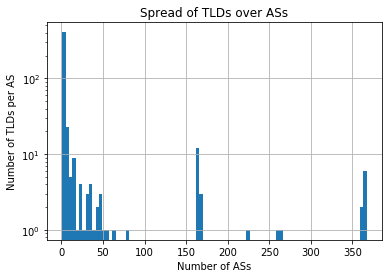

In [101]:
ax = df_asns.groupby('asn').tld.nunique().hist(bins = int((maxc - minc) / 4), range=(minc, maxc))
ax.set_yscale('log')
set_text(ax, 'Spread of TLDs over ASs', 'Number of ASs', 'Number of TLDs per AS')

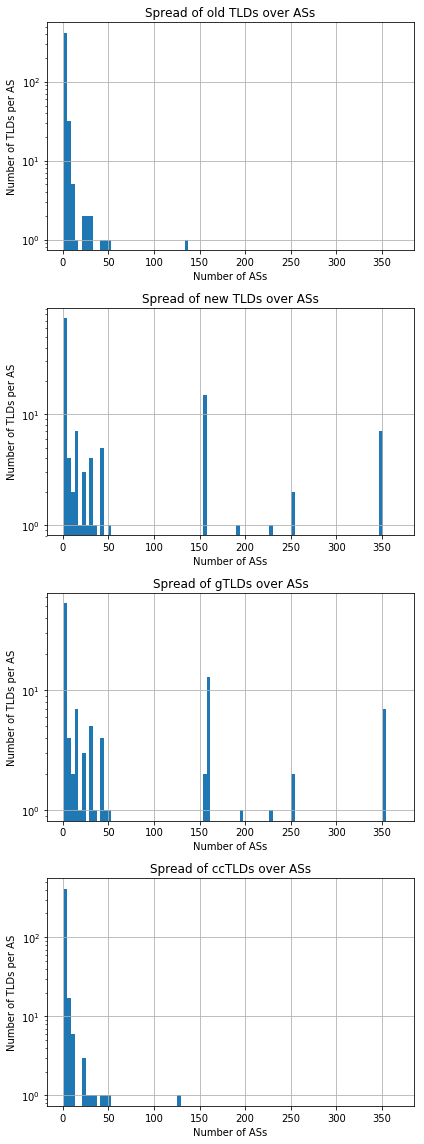

In [104]:
fig, axes = plt.subplots(nrows=len(tld_groups))

for i, group in enumerate(tld_groups):    
    ax = df_asns[df_asns.tld.isin(tld_groups[group])].groupby('asn').tld.nunique().hist(bins = int((maxc - minc) / 4), 
                                                                                        range=(minc, maxc),
                                                                                        figsize = (6, 4 * len(tld_groups)),
                                                                                        ax = axes[i])
    
    ax.set_yscale('log')
    set_text(ax, 'Spread of {} over ASs'.format(group), 'Number of ASs', 'Number of TLDs per AS')
    
fig.tight_layout()

# Reachability

In [113]:
data_reach = read_json('data/data_reach.json')

In [114]:
df_reach = pd.DataFrame(data_reach)

In [115]:
def xyz(df, x, y, z, columns, index):
    data = [df.loc[df[x] == p].loc[df[y] == q][z].count()
            for p in [True, False] for q in [True, False]]

    df_new = pd.DataFrame(data,
                          columns = columns,
                          index = index)
    
    return df_new

In [116]:
x = 'tcp'
y = 'udp'
z = 'ns'
columns = ['protocols']
index = ['tcp + udp', 'tcp', 'udp', 'none']

df_reach_all = xyz(df_reach, x, y, z, columns, index)
df_reach_ipv4 = xyz(df_reach.loc[df_reach.ip.str.contains('\.')], x, y, z, columns, index)
df_reach_ipv6 = xyz(df_reach.loc[df_reach.ip.str.contains(':')], x, y, z, columns, index)
df_reach_old = xyz(df_reach[df_reach.tld.isin(old_tlds)], x, y, z, columns, index)
df_reach_new = xyz(df_reach[df_reach.tld.isin(new_tlds)], x, y, z, columns, index)
df_reach_cctlds = xyz(df_reach[df_reach.tld.isin(cctlds)], x, y, z, columns, index)
df_reach_gtlds = xyz(df_reach[df_reach.tld.isin(gtlds)], x, y, z, columns, index)

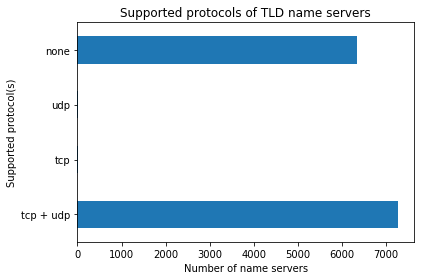

In [117]:
ax = df_reach_all.protocols.plot.barh()
ax.set_xlabel('Number of name servers')
ax.set_ylabel('Supported protocol(s)')
ax.set_title('Supported protocols of TLD name servers')
fig = ax.get_figure()
fig.tight_layout()
fig.savefig("imgs/reachability.pdf")

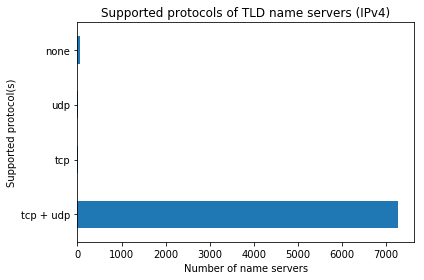

In [118]:
ax = df_reach_ipv4.protocols.plot.barh()
ax.set_xlabel('Number of name servers')
ax.set_ylabel('Supported protocol(s)')
ax.set_title('Supported protocols of TLD name servers (IPv4)')
fig = ax.get_figure()
fig.tight_layout()
fig.savefig("imgs/reachability_ipv4.pdf")

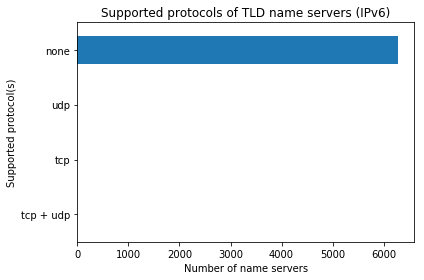

In [119]:
ax = df_reach_ipv6.protocols.plot.barh()
ax.set_xlabel('Number of name servers')
ax.set_ylabel('Supported protocol(s)')
ax.set_title('Supported protocols of TLD name servers (IPv6)')
fig = ax.get_figure()
fig.tight_layout()
fig.savefig("imgs/reachability_ipv6.pdf")

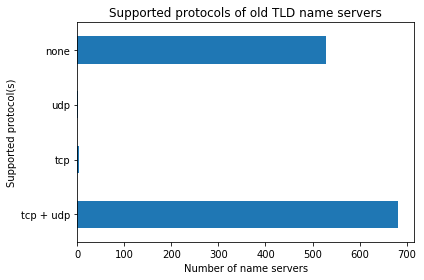

In [120]:
ax = df_reach_old.protocols.plot.barh()
ax.set_xlabel('Number of name servers')
ax.set_ylabel('Supported protocol(s)')
ax.set_title('Supported protocols of old TLD name servers')
fig = ax.get_figure()
fig.tight_layout()
fig.savefig("imgs/reachability_old.pdf")

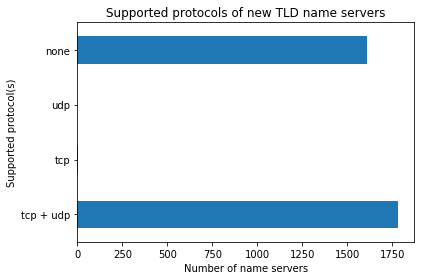

In [121]:
ax = df_reach_new.protocols.plot.barh()
ax.set_xlabel('Number of name servers')
ax.set_ylabel('Supported protocol(s)')
ax.set_title('Supported protocols of new TLD name servers')
fig = ax.get_figure()
fig.tight_layout()
fig.savefig("imgs/reachability_new.pdf")

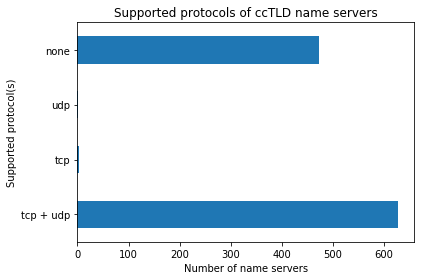

In [122]:
ax = df_reach_cctlds.protocols.plot.barh()
ax.set_xlabel('Number of name servers')
ax.set_ylabel('Supported protocol(s)')
ax.set_title('Supported protocols of ccTLD name servers')
fig = ax.get_figure()
fig.tight_layout()
fig.savefig("imgs/reachability_cctlds.pdf")

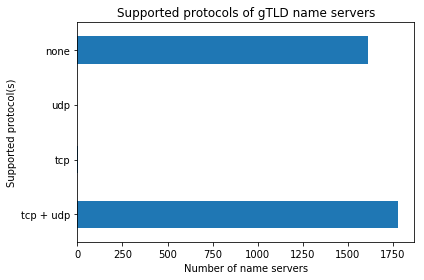

In [123]:
ax = df_reach_gtlds.protocols.plot.barh()
ax.set_xlabel('Number of name servers')
ax.set_ylabel('Supported protocol(s)')
ax.set_title('Supported protocols of gTLD name servers')
fig = ax.get_figure()
fig.tight_layout()
fig.savefig("imgs/reachability_gtlds.pdf")

# Credibility

In [124]:
data_cred = read_json('data/data_cred.json')

In [125]:
# Downloads and loads file with algorithm numbers from IANA
!wget https://www.iana.org/assignments/dns-sec-alg-numbers/dns-sec-alg-numbers-1.csv -O data/lists/dnssec_algorithm_numbers.csv
reader = csv.reader(open('data/lists/dnssec_algorithm_numbers.csv', 'r'))

--2017-07-12 20:35:45--  https://www.iana.org/assignments/dns-sec-alg-numbers/dns-sec-alg-numbers-1.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving www.iana.org... 192.0.32.8, 2620:0:2d0:200::8
Connecting to www.iana.org|192.0.32.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘data/lists/dnssec_algorithm_numbers.csv’

data/lists/dnssec_a     [ <=>                ]   1.52K  --.-KB/s    in 0s      

2017-07-12 20:35:46 (7.25 MB/s) - ‘data/lists/dnssec_algorithm_numbers.csv’ saved [1559]



In [126]:
df_cred = pd.DataFrame(data_cred)

In [127]:
algorithms = {}

for row in reader:
   k, _, v, _, _, _ = row
   algorithms[k] = v

In [128]:
for algorithm_number in algorithms:
    df_cred['algorithm'] = df_cred['algorithm'].replace(algorithm_number, algorithms[algorithm_number])

In [129]:
ax = df_cred.algorithm.value_counts().plot.pie(figsize = pie, autopct='%.2f')
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Distribution of DNSSEC algorithms')
fig = ax.get_figure()
# fig.tight_layout()
fig.savefig("imgs/dnssec_algs.pdf")

NameError: name 'pie' is not defined

In [130]:
dnssec_record_counts = [df_cred.loc[df_cred.dnskey == x].loc[df_cred.ds == y].count().tld 
                        for x in [True, False] for y in [True, False]]

df_cred2 = pd.DataFrame(dnssec_record_counts, 
                        columns = ['dnssec_record_counts'],
                        index = ['ds + dnskey', 'ds', 'dnskey', 'none'])

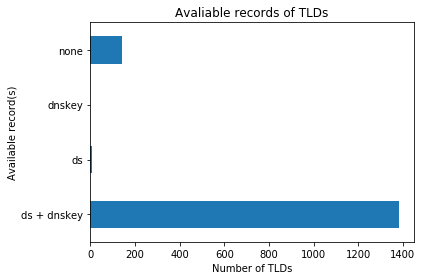

In [131]:
ax = df_cred2.dnssec_record_counts.plot.barh()
ax.set_ylabel('Available record(s)')
ax.set_xlabel('Number of TLDs')
ax.set_title('Avaliable records of TLDs')
fig = ax.get_figure()
fig.tight_layout()
fig.savefig("imgs/dnssec.pdf")

In [ ]:
dnssec_record_counts = [df_cred[df_cred.tld.isin(new_tlds)].loc[df_cred.dnskey == x].loc[df_cred.ds == y].count().tld 
                        for x in [True, False] for y in [True, False]]

df_cred2 = pd.DataFrame(dnssec_record_counts, 
                        columns = ['dnssec_record_counts'],
                        index = ['ds + dnskey', 'ds', 'dnskey', 'none'])

In [ ]:
df_cred[df_cred.tld.isin(new_tlds)].loc[df_cred.dnskey == False]

In [ ]:
ax = df_cred2.dnssec_record_counts.plot.barh()
ax.set_ylabel('Available record(s)')
ax.set_xlabel('Number of TLDs')
ax.set_title('Avaliable records of new TLDs')
fig = ax.get_figure()
fig.tight_layout()
fig.savefig("imgs/dnssec_new.pdf")

In [ ]:
dnssec_record_counts = [df_cred[df_cred.tld.isin(old_tlds)].loc[df_cred.dnskey == x].loc[df_cred.ds == y].count().tld 
                        for x in [True, False] for y in [True, False]]

df_cred2 = pd.DataFrame(dnssec_record_counts, 
                        columns = ['dnssec_record_counts'],
                        index = ['ds + dnskey', 'ds', 'dnskey', 'none'])

In [ ]:
ax = df_cred2.dnssec_record_counts.plot.barh()
ax.set_ylabel('Available record(s)')
ax.set_xlabel('Number of TLDs')
ax.set_title('Avaliable records of old TLDs')
fig = ax.get_figure()
fig.tight_layout()
fig.savefig("imgs/dnssec_old.pdf")

In [ ]:
dnssec_record_counts = [df_cred[df_cred.tld.isin(cctlds)].loc[df_cred.dnskey == x].loc[df_cred.ds == y].count().tld 
                        for x in [True, False] for y in [True, False]]

df_cred2 = pd.DataFrame(dnssec_record_counts, 
                        columns = ['dnssec_record_counts'],
                        index = ['ds + dnskey', 'ds', 'dnskey', 'none'])

In [ ]:
ax = df_cred2.dnssec_record_counts.plot.barh()
ax.set_ylabel('Available record(s)')
ax.set_xlabel('Number of TLDs')
ax.set_title('Avaliable records of ccTLDs')
fig = ax.get_figure()
fig.tight_layout()
fig.savefig("imgs/dnssec_cctlds.pdf")

In [ ]:
dnssec_record_counts = [df_cred[df_cred.tld.isin(gtlds)].loc[df_cred.dnskey == x].loc[df_cred.ds == y].count().tld 
                        for x in [True, False] for y in [True, False]]

df_cred2 = pd.DataFrame(dnssec_record_counts, 
                        columns = ['dnssec_record_counts'],
                        index = ['ds + dnskey', 'ds', 'dnskey', 'none'])

In [ ]:
ax = df_cred2.dnssec_record_counts.plot.barh()
ax.set_ylabel('Available record(s)')
ax.set_xlabel('Number of TLDs')
ax.set_title('Avaliable records of gTLDs')
fig = ax.get_figure()
fig.tight_layout()
fig.savefig("imgs/dnssec_gtlds.pdf")

In [ ]:
df_cred.loc[df_cred.dnskey == False].loc[df_cred.ds]

# Performance

In [ ]:
data_perf = read_json('data/data_perf.json')

In [ ]:
df_perf = pd.DataFrame(data_perf)
maxc = int(df_perf.rt.max())
minc = int(df_perf.rt.min())

In [ ]:
ax = df_perf.rt.hist(bins = 153, range = (0, 1400))
ax.set_title("Mean response times of all TLDs")
ax.set_xlabel("Response time (ms)")
ax.set_ylabel("Number of TLDs")
fig = ax.get_figure()
fig.savefig("imgs/perf.pdf")

In [ ]:
ax = df_perf[df_perf.tld.isin(new_tlds)].rt.hist(bins = 153, range = (0, 1400))
ax.set_title("Mean response times of new TLDs")
ax.set_xlabel("Response time (ms)")
ax.set_ylabel("Number of TLDs")
fig = ax.get_figure()
fig.savefig("imgs/perf_new.pdf")

In [ ]:
ax = df_perf[df_perf.tld.isin(old_tlds)].rt.hist(bins = 153, range = (0, 1400))
ax.set_title("Mean response times of old TLDs")
ax.set_xlabel("Response time (ms)")
ax.set_ylabel("Number of TLDs")
fig = ax.get_figure()
fig.savefig("imgs/perf_old.pdf")

In [ ]:
ax = df_perf[df_perf.tld.isin(gtlds)].rt.hist(bins = 153, range = (0, 1400))
ax.set_title("Mean response times of gTLDs")
ax.set_xlabel("Response time (ms)")
ax.set_ylabel("Number of TLDs")
fig = ax.get_figure()
fig.savefig("imgs/perf_gtlds.pdf")

In [ ]:
ax = df_perf[df_perf.tld.isin(cctlds)].rt.hist(bins = 153, range = (0, 1400))
ax.set_title("Mean response times of ccTLDs")
ax.set_xlabel("Response time (ms)")
ax.set_ylabel("Number of TLDs")
fig = ax.get_figure()
fig.savefig("imgs/perf_cctlds.pdf")

In [ ]:
maxc = df_perf.timeouts.max()
minc = df_perf.timeouts.min()

ax = df_perf.timeouts.hist(bins = maxc - minc + 1, 
                           range = (minc, maxc + 1), 
                           align = 'left')

ax.set_xlabel("Number of timeouts")
ax.set_ylabel("Number of TLDs")
fig = ax.get_figure()
fig.savefig("imgs/perf_timeouts.pdf")

# Anycast

In [19]:
data_ac = read_json('data/data_ac.json')

In [20]:
for datum in data_ac:
    for probe in datum['probes']:
        if datum['probes'][probe]:
            datum['probes'][probe] = np.mean(datum['probes'][probe])

In [21]:
df_ac = pd.DataFrame([datum['probes'] for datum in data_ac], index = [datum['ns'] for datum in data_ac]).transpose()

In [22]:
anycast_probes = [
    # North America
    {'id': 22447, 'country-code': 'US', 'city': 'San Francisco'},
    {'id': 14233, 'country-code': 'US', 'city': 'Denver'},
    {'id': 25081, 'country-code': 'US', 'city': 'Washington'},
    # South America
    {'id': 31450, 'country-code': 'CR', 'city': 'San Jose'},
    {'id': 30185, 'country-code': 'BR', 'city': 'Sao Paulo'},
    {'id': 30123, 'country-code': 'CL', 'city': 'Santiago'},
    # Europe
    {'id': 32669, 'country-code': 'GR', 'city': 'Athens'},
    {'id': 31479, 'country-code': 'RU', 'city': 'Moscow'},
    {'id': 29762, 'country-code': 'ES', 'city': 'Madrid'},
    {'id': 26610, 'country-code': 'NL', 'city': 'Utrecht'},
    # Africa
    {'id': 22458, 'country-code': 'ZA', 'city': 'Cape Town'},
    {'id': 13258, 'country-code': 'AE', 'city': 'Dubai'},
    {'id': 28493, 'country-code': 'SN', 'city': 'Dakar'},
    # Asia
    {'id': 28819, 'country-code': 'JP', 'city': 'Tokyo'},
    {'id': 28964, 'country-code': 'KR', 'city': 'Seoul'},
    {'id': 6107,  'country-code': 'IN', 'city': 'Mumbai'},
    {'id': 25047, 'country-code': 'HK', 'city': 'Hong Kong'},
    {'id': 26378, 'country-code': 'KG', 'city': 'Bishkek'},
    # Oceania
    {'id': 25208, 'country-code': 'AU', 'city': 'Sydney'},
    {'id': 28226, 'country-code': 'NZ', 'city': 'Welington'}
]

In [23]:
df_ac['cc'] = df_ac.index

for probe in anycast_probes:
    df_ac['cc'] = df_ac['cc'].replace(str(probe['id']), '{} ({})'.format(probe['city'], probe['country-code']))

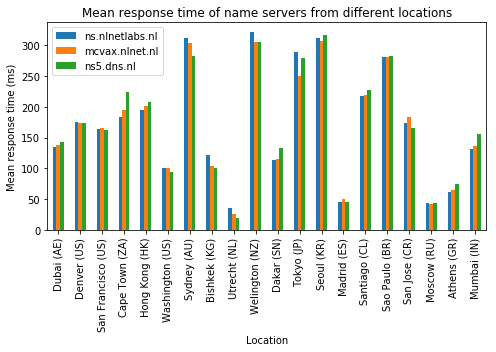

In [24]:
ax = df_ac.plot.bar(figsize = (7, 5))
ax.set_xticklabels(list(df_ac.cc), rotation=90)
ax.set_title('Mean response time of name servers from different locations')
ax.set_xlabel('Location')
ax.set_ylabel('Mean response time (ms)')
fig = ax.get_figure()
fig.tight_layout()
fig.savefig("imgs/anycast.pdf")

# Multi indexed table

In [43]:
# Multi indexed pandas table of network diversity data
data_asns = read_json('data/data_asns.json')

tlds, nss, ips, asns = [], [], [], []

for datum in data_asns:
    tlds.append(datum['tld'])
    nss.append(datum['ns'])
    ips.append(datum['ip'])
    asns.append(datum['asn'])
    
ix = pd.MultiIndex.from_arrays([tlds, nss, ips], names=['tld', 'ns', 'ip'])
df_asns = pd.DataFrame({'asn': asns}, index = ix)

In [44]:
df_asns

asn
tld  ns                        ip                                 
AAA  ns3.dns.nic.aaa           156.154.159.2                 12008
                               2610:a1:1073::2               12008
     ns4.dns.nic.aaa           156.154.156.2                 12008
                               2610:a1:1074::2               12008
     ns5.dns.nic.aaa           156.154.157.2                 12008
                               2610:a1:1075::2               12008
     ns2.dns.nic.aaa           156.154.145.2                 19911
                               2610:a1:1072::2               19911
     ns1.dns.nic.aaa           156.154.144.2                 12008
                               2610:a1:1071::2               12008
     ns6.dns.nic.aaa           156.154.158.2                 12008
                               2610:a1:1076::2               12008
AARP ac1.nstld.com             192.42.173.30                 36618
                               192.42.173.30                 36619
                               192.42.173.30                 36620
                               192.42.173.30                 36623
                               192.42.173.30                 36624
                               192.42.173.30                 36625
                               2001:500:120::30              36625
     ac4.nstld.com             192.42.176.30                 36617
                               192.42.176.30                 36619
                               192.42.176.30                 36620
                               192.42.176.30                 36621
                               192.42.176.30                 36622
                               192.42.176.30                 36623
                               192.42.176.30                 36625
                               192.42.176.30                 36628
                               192.42.176.30                 36632
                               2001:500:123::30              36625
     ac3.nstld.com             192.42.175.30                 36616
...                                                            ...
MD   dns-md.rotld.ro           192.162.16.19                  3233
                               2a03:5e80:0:4:192:162:16:19    3233
     ns-int.dns.md             217.26.144.5                  28990
     nsb.dns.md                217.26.144.15                 28990
     md.cctld.authdns.ripe.net 193.0.9.93                   197000
                               2001:67c:e0::93              197000
     nsf.dns.md                86.106.212.21                  8926
     ns-ext.isc.org            204.152.184.64                 1280
                               2001:4f8:0:2::13               1280
MG   censvrns0001.ird.fr       91.203.32.147                 44850
     b.mg.dyntld.net           199.19.6.24                   15135
                               2001:500:96::24               15135
     ns.dts.mg                 196.192.32.2                  37054
     ns-mg.malagasy.com        87.98.132.231                 16276
     ns.nic.mg                 196.192.42.153                37054
     a.mg.dyntld.net           199.19.5.24                   15135
                               2001:500:92::24               15135
MR   ns1.nic.mr                41.188.65.193                 29544
     ns3.nic.fr                192.134.0.49                   2486
                               2001:660:3006:1::1:1           2486
     censvrns0001.ird.fr       91.203.32.147                 44850
     ns.univ-nkc.mr            82.151.64.1                   29544
MX   i.mx-ns.mx                207.248.68.1                  12008
     m.mx-ns.mx                200.94.176.1                  28498
                               2001:13c7:7000::1             28498
     c.mx-ns.mx                192.100.224.1                 28499
                               2001:1258::1                  28499
     o.mx-ns.mx                200.23.1.1  